In [ ]:
!git clone https://github.com/0xpantera/UFM-AI-22.git
%cd UFM-AI-22
from install import *
install_requirements()

fatal: destination path 'UFM-AI-22' already exists and is not an empty directory.
/content/UFM-AI-22
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


# Transformers en prod

En las clases pasadas, hemos visto cómo se pueden ajustar los transformers para producir excelentes resultados en una amplia gama de tareas. Sin embargo, en muchas situaciones, el accuracy (o cualquier métrica para la que estemos optimizando) no es suficiente; nuestro modelo de última generación no es muy útil si es demasiado lento o grande para cumplir con los requisitos de negocio de nuestra aplicación. Una alternativa obvia es entrenar un modelo más rápido y compacto, pero la reducción de la capacidad del modelo suele ir acompañada de una degradación del rendimiento. Entonces, ¿qué podemos hacer cuando necesitamos un modelo rápido, compacto y muy accurate (uso accurate en vez de preciso porque tienen diferente significado técnico e.i. precision != accuracy)?

En este notebook, vamos a explorar cuatro técnicas complementarias que se pueden usar para acelerar las predicciones y reducir el uso de memoria de los transformers: knowledge distillation, quantization, pruning, y graph optimization con el Open Neural Network Exchange (ONNX) format y ONNX Runtime (ORT). También veremos cómo se pueden combinar algunas de estas técnicas para producir mejoras significativas en el rendimiento.

Para ilustrar los beneficios y los trade-offs asociados con cada técnica, utilizaremos _intent detection_ como caso de estudio; este es un componente importante de los asistentes basados en texto, donde las bajas latencias son fundamentales para mantener una conversación en tiempo real.


## Intent detection como caso de estudio

Supongamos que estamos tratando de crear un asistente basado en texto para el call center de nuestra empresa para que los clientes puedan solicitar el saldo de su cuenta o hacer reservas sin necesidad de hablar con un agente humano. Para comprender los objetivos de un cliente, nuestro asistente deberá poder clasificar una amplia variedad de texto en lenguaje natural en un conjunto de acciones o intenciones predefinidas. Por ejemplo, un cliente podría enviar un mensaje como el siguiente sobre un viaje:
> Hey, I’d like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passen‐ ger van

y nuestro clasificador de intenciones podría categorizarlo automáticamente como una intención de alquiler de autos, lo que luego desencadena una acción y una respuesta. Para ser robusto en un entorno de producción, nuestro clasificador también deberá poder manejar consultas _out-of-scope_, donde un cliente realiza una consulta que no pertenece a ninguna de las intenciones predefinidas y el sistema debe generar una respuesta fallback.

Como baseline hemos fine-tuned un modelo basado en BERT que alcanza 94% accuracy en el dataset CLINC150[1]. Este dataset inlcuye 22,500 in-scope queries a traves de 150 intents y 10 dominios como banca y viajes. Tambien incluye 1,200 queries out-of-scope que pertenecen a un intent class `oos`. En realidad tambien recolectariamos un dataset in-house, pero usar data publica es una excelente forma de iterar rapidamente y generar resultado preliminares.

Para empezar bajemos nuestro modelo fine-tuned de Hugging Face Hub y hagamos un pipeline de clasificacion de texto:

[1] S. Larson et al., [“An Evaluation Dataset for Intent Classification and Out-of-Scope Prediction”](https://arxiv.org/abs/1909.02027), (2019).

In [ ]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

Ahora pasemos un query para obtener la prediccion del intent y el confidence score del modelo:

In [ ]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
    Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

## Creando un benchmark de rendimiento

Como otros modelos de ML, desplegar transformers en entornos de produccion involucra un trade-off entre varias restricciones, las mas comunes siendo[2]:

_Model performance_
- Que tan bien rinde nuestro modelo en un test set bien elaborado que refleja la data de produccion? Especialmente importante cuando el costo de hacer errores es grande o cuando corremos predicciones sobre millones de ejemplos y pequenias mejoras a las metricas del modelo se traducen en grandes ganancias.

_Latency_
- Que tan rapido es nuestro modelo para servir predicciones? Usualmente nos interesa en entornos de tiempo real que manejan mucho trafico. [Como Stack Overflow hizo con su clasificador para detectar comments malos](https://stackoverflow.blog/2020/04/09/the-unfriendly-robot-automatically-flagging-unwelcoming-comments/)

_Memory_
- Como podemos desplegar modelos de billones de parametros como GPT-2 o T5 que requieren gigabytes de almacenamiento y RAM? Especialmente importante en mobile o edge devices, donde el modelo tiene que generar predicciones sin acceso a un servidor cloud.

No abordar estas restricciones puede tener un impacto negativo en UX. Usualmente, puede generar costos crecientes en servidores en la nube que talvez solo necesitan procesar pocos requests. Para explorar como se puede optimizar cada una de estas restricciones con varias tecnicas de compresion, comencemos creando un benchmark simple que mida cada cantidad para un pipeline y un test set:

[2] Como describe Emmanuel Ameisen en _Building Machine Learning Powered Applications_ (O'Reilly), las metricas de negocio o de producto son las mas importantes a considerar. No importa que tan accurate sea el modelo si no resuelve un problema que le importa al negocio.

In [ ]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        pass

    def compute_size(self):
        pass

    def time_pipeline(self):
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics


Definimos el parametro `optim_type` para mantener un record de las diferentes tecnicas de optimizacion que vamos a ver. Vamos a usar el metodo `run_benchmark()` para recolectar todas las metricas en un diccionario, con las llaves dadas por `optim_type`.

Empecemos a llenar el esqueleto calculando el accuracy del modelo en el test set. Primero necesitamos data para evaluar. Vamos a descargar el dataset CLINC150 que fue usado para fine-tune nuestro modelo baseline:

In [ ]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

  0%|          | 0/3 [00:00<?, ?it/s]

El `plus` se refiere al subset que contiene ejemplos de entrenamiento out-of-scope. Cada ejemplo en el dataset contiene un query en la columna `text` y su correspondiente intent. Vamos a usar el test set para benchmark nuestros modelos. Veamos uno de los ejemplos:

In [ ]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

Los intents estan como IDs, pero podemos obtener un mapeo a strings (y vice versa) accesando el atributo `features` del datastet:

In [ ]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

Ahora implementemos el metodo `compute_accuracy()` de `PerformanceBenchmark`. Como el dataset es balanceado en sus clases de intent, vamos a usar accuracy como metrica. Podemos cargar esta metrica de 🤗 Datasets:

In [ ]:
from datasets import load_metric

accuracy_score = load_metric("accuracy")

La metrica accuracy espera que las predicciones y referencias (i.e. las etiquetas reales) sean enteros. Podemos usar el pipeline para extraer las predicciones del campo `text` y usar el metodo `str2int()` de nuestro objeto `intents` para mapear cada prediccion a su ID correspondiente. El siguiente codigo recolecta todas las predicciones y etiquetas en listas antes de retornar el accuracy sobre el dataste.

In [ ]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchamrk.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

Ahora calculemos el tamanio de nuestro modelo usando la funcion `torch.save()` de PyTorch para serializar el modelo a disco. Debajo, `torch.save()` usa el modulo `pickle` de python y puede usarse para guardar cualquier cosa desde modelos a tensores a objetos ordinarios de Python. En PyTorch, es recomendado guardar el modelo usando su `state_dict` que es un diccionario de python que mapea cada capa en el modelo a sus parametros aprendibles (i.e., weights y biases). Veamos que esta guardado en el `state_dict` de nuestro modelo baseline:

In [ ]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

Cada key/value pair corresponde a una capa y tensor especifico en BERT. Asi que si guardamos el modelo con:

In [ ]:
import torch
torch.save(pipe.model.state_dict(), "model.pt")

podemos usar la funcion `Path.stat()` del modulo `pathlib` de Python para obtener informacion de los archivos. En particular, `Path("model.pt").stat().st_size` nos va a dar el tamanio del modelo en bytes.

In [ ]:
 from pathlib import Path

 def compute_size(self):
     """This overrides the PerformanceBenchmark.compute_size() method"""
     state_dict = self.pipeline.model.state_dict()
     tmp_path = Path("model.pt")
     torch.save(state_dict, tmp_path)
     # calculate size in megabytes
     size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
     # Delete temp file
     tmp_path.unlink()
     print(f"Model size (MB) - {size_mb:.2f}")
     return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

Finalmente implementemos la funcion `time_pipeline()` para poder calcular la latencia promedio por query. Para esta aplicacion, latencia se refiere al tiempo que toma alimentar el query text al pipeline y retornar un intent predecido del modelo. Bajo el capo, el pipeline tambien tokeniza el texto pero esto es alrededor de mil veces mas rapido que generar las predicciones y por tanto agrega una contribucion negligente a la latencia general. Una forma facil de medir el tiempo de ejecucion de un pedazo de codigo es con la funcion `perf_counter()` del modulo `time` de pythohn. Esta tiene mejor resolucion que `time.time()`.

Podemos usar `perf_counter()` para timear nuestro pipeline pasando nuestro test query y calculando la diferencia de tiempo en milisegundos entre principio y fin:

In [ ]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 157.925
Latency (ms) - 123.508
Latency (ms) - 276.892


Estos resultados exhiben bastante spread en latencias y sugieren que tomar el tiempo de un solo pase a traves del pipleine nos puede dar resultados muy diferentes cada vez que corremos el codigo. En vez, vamos a recolectar las latencias a traves de varias corridas y luego usar la distribucion para calcular la media y desviacion estandar. Esto nos va adar una mejor idea del spread de valores. Adicional incluimos una fase para calentar el CPU antes:

In [ ]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +/- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

Para mantener las cosas simples, vamos a usar el mismo `query` para el benchmark de todos nuestros modelos. En general, la latencia depende del largo del query y es buena practica hacer el bencmark con queries que probablemente nos topemos en entornos de produccion.

Ahora probemos nuestra clase `PErformancBenchmark`. Vamos a hacer un benchmark de nuestro BERT baseline. Para el modelo baseline solo tenemos que pasar el pipeline y el dataset. Recolectamos los resultados en el diccionario `perf_metrics` para llevar un registro del performance de cada modelo:

In [ ]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.16
Average latency (ms) - 131.51 +/- 33.63
Accuracy on test set - 0.867


Ahora que tenemos un punto de referencia, veamos la primera tecnica de compresion.

## Knowledge Distillation para hacer modelos mas pequenios

Knowledge distillation es un metodo de general para entrenar a un modelo _student_ mas pequenio para imitar el comportamiento de un modelo _teacher_ mas lento, mas grande pero con mejor desempeño. Introducido originalmente en 2006 en el contexto de los ensemble models,[3] mas tarde se popularizo en un famoso articulo en el 2015 que generalizo el metodo a DNNs y lo aplico a la clasificacion de imagenes y al reconocimiento automatico de voz.[4]

KD se ha vuelto una estrategia popular para comprimir modelos gigantes (el mas grande hasta hace poco tenia mas de 1 trillon de parametros)[5] y hacerlos mas adecuados para desarrollar aplicaciones practicas.

[3] C. Buciluă et al., “Model Compression,” Proceedings of the 12th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (August 2006): 535–541, https://doi.org/10.1145/1150402.1150464.

[4] G. Hinton, O. Vinyals, and J. Dean, [“Distilling the Knowledge in a Neural Network”](https://arxiv.org/abs/1503.02531), (2015).

[5] W. Fedus, B. Zoph, and N. Shazeer, [“Switch Transformers: Scaling to Trillion Parameter Models with Simple
and Efficient Sparsity”](https://arxiv.org/abs/2101.03961), (2021).

### Knowledge distillation para fine-tuning

Para tareas supervisadas como fine-tuning, la idea principal es aumentar las etiquetas ground truth del _teacher_ con una distribucion de "soft probabilities" que proveen informacion complementaria para que el _student_ aprenda de ella. Por ejemplo, si nuestro clasificador BERT asigna altas probabilidades a multiples intents, entonces esto es una senial que estos intents estan cercanos en el feature space. Al entrenar al student a imitar estas probabilidades, la meta es destilar algo de este "dark knowledge"[6] que el teacher ha aprendido. Es decir, conocimiento no disponible de las etiquetas unicamente.

[6] Geoff Hinton invento este termino en una [platica](https://www.ttic.edu/dl/dark14.pdf) para referirse a la observacion de que las "soft probabilities" revelan el conocimiento escondido del teacher.

Matematicamente, funciona de la siguiente manera:
Supongan que alimentamos una secuencia de input $x$ al teacher para generar un vector de logits $z(x) = [z_1(x),...,z_N(x)]$. Podemos convertir estos logits en probabilidades aplicando softmax:

$\frac{exp(z_i(x))}{\sum_j exp(z_i(x))}$

Esto no es exactamente lo que queremos porque en muchos casos el teacher va a asignar una alta probabilidad a una clase, con el resto de clases con probabilidades cercanas a cero. Cuando eso sucede el teacher no esta proveyendo mucha informacion adicional, entonces en vez "suavizamos" las probabilidades escalando los logits con un hiperparametro de temperatura $T$ antes de aplicar softmax[7]:

$p_i(x) = \frac{exp(z_i(x)/T)}{\sum_j exp(z_i(x)/T)}$

valores mas altos de T van a producir una distribucion de probabilidades mas suave sobre las clases y revelar mucho mas informacion sobre el limite de decision que el teacher ha aprendido de cada ejemplo de entrenamiento. Cuando $T=1$ recuperamos la distribucion softmax original.

Como el student tambien produce probabilidades suavizadas $q_i(x)$ por su lado, podemos usar [Kullback-Leibler (KL)](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) divergence para medir la diferencia entre las dos distribuciones de probabilidades:

$D_{KL}(p,q) = \sum_i p_i(x) log \frac{p_i(x)}{q_i(x)}$

con KL divergence podemos calcular cuanto se pierde cuando aproximamos la distribucion de probabilidades del teacher con el student. Esto nos permite definir un loss para knowledge distillation:

$L_{KD} = T^2D_{KL}$

donde $T^2$ es un factor de normalizacion para tomar en cuenta el hecho que la magnitud de las gradientes producidas por etiquetas "suaves" escala como $1/T^2$. Para tareas de clasificacion el student loss es un promedio ponderado del distillation loss con el usual cross-entropy loss $L_{CE}$ de las etiquetas ground truth:

$L_{student} = \alpha L_{CE} + (1 - \alpha)L_{KD}$

donde $\alpha$ es un hiperparametro que controla la fuerza relativa de cada loss. 

## Knowledge distillation para pretraining

KD tambien se puede usar durante pretraining para crear un student de uso general que puede ser fine-tuned para otras tareas. En este caso, el teacher es un LLM preentrenado como BERT, que transfiere su conocimiento sobre masked language modeling al student. Por ejemplo, en el paper de DistilBERT[8], el masked language modeling loss $L_{mlm}$ es aumentado con un termino de knowledge distillation y un cosine embedding loss $L_{cos} = 1 - cos(h_s, h_t)$ para alinear las direcciones de los hidden state vectors entre el teacher y el student:

$L_{DistilBERT} = \alpha L_{mlm} + \beta L_{KD} + \gamma L_{cos}$

Como ya tenemos un modelo base BERT fine-tuned, veamos como podemos usar knowledge distillation para fine-tune un modelo mas rapido y pequenio. Para hacer esto necesitamos una forma de aumentar el cross-entropy loss con un termino $L_{KD}$. Podemos hacer esto creando nuestro propio trainer.

### Creando un trainer para knowledge distillation

Para implementar KD necesitamos agregar un par de cosas a la clase base `Trainer`:
- Los nuevos hiperparametros $\alpha$ y $T$, que controlan el peso relativo del distillation loss y que tanto debe ser suavizada la distribucion de probabilidades de las etiquetas
- El modelo teacher fine-tuned, en nuestro caso es BERT-base
- Una nueva loss function que combina cross-entropy loss con el knowledge distillation loss

Agregar los nuevos hiperparametros es bastante simple, solo tenemos que subclass `TrainingArguments` e incluirlos como nuevos atributos:

[8] V. Sanh et al., [“DistilBERT, a Distilled Version of BERT: Smaller, Faster, Cheaper and Lighter”](https://arxiv.org/abs/1910.01108), (2019).

In [ ]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

Para el trainer necesitamos una nueva loss function. Para implementar esto tenemos que subclass `Trainer` y sobreescribir el metodo `compute_loss()` para incluir el termino knowledge distillation loss $L_{KD}$:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

Cuando creamos una instancia de `DistillationTrainer` pasamos un argumento `teacher_model` con un teacher que ya ha sido fine-tuned en nuestra tarea. Luego, en el metodo `compute_loss()` extraemos los logits del student y teacher, los escalamos por el temperature, y luego los normalizamos con un softmax antes de antes de pasarlos a la funcion `nn.KLDivLoss()` de PyTorch para calcular el KL divergence. Una cosa rara de `nn.KLDivLoss()` es que espera los inputs en forma de log probabilities y las etiquetas en probabilidades normales. Por eso usamos `F.log_softmax()` para normalizar los logits del student, mientras que los logits del teacher se convierten a probabilidades con un softmax estandar. El argumento `reduction=batchmean` en `nn.KLDivLoss()` especifica que promediamos los losses sobre la dimension batch.

## Escogiendo una buena inicializacion del Student

Ahora que tenemos nuestro trainer custom, la primera pregunta es que modelo preentrenado escogemos para nuestro student? En general deberiamos escoger un modelo pequenio para que el student reduzca la latencia y memoria. Una buena heuristica de la literatura es que KD funciona mejor cuando el teacher y student son del mismo _model type_[9]. Una posible razon para esto es que diferentes tipos de modelos, como BERT y RoBERTa, tienen diferentes output embedding spaces, que hace dificil que el student imite al teacher. En nuestro caso el teacher es BERT, entonces DistilBERT es un candidato natural para inicializar el student ya que tiene 40% menos parametros y ha sido demostrado que obtiene buenos resultados.

Primero necesitamos tokenizar y codificar nuestros queries. Inicialicemos un tokenizador de DistilBERT y creemos una funcion `tokenize_text()` para el preprocesamiento:


[9] Y. Kim and H. Awadalla, [“FastFormers: Highly Efficient Transformer Models for Natural Language Under‐ standing”](https://arxiv.org/abs/2010.13382), (2020).

In [ ]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Aqui quitamos la columna `text` ya que no la necesitamos, y tambien renombramos la columna `intent` a `labels` para que pueda ser detectada automaticamente por el trainer.

Ahora que hemos procesado nuestro texto, lo siguiente es definir los hiperparametros y la funcion `compute_metrics()` de nuestro `DistillationTrainer`. Vamos a cargar nuestros modelos a Hugging Face Hub:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Luego, definimos las metricas para trackear durante el entrenamiento. Seguiremos usando accuracy como metrica principal. Podemos reusar nuestra funcion `accuracy_score()` en la funcion `compute_metrics()` que vamos a incluir en `DistillationTrainer`:

In [ ]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

En esta funcion, las predicciones de la cabeza de modelado de secuencia vienen en forma de logits, asi que usamos `np.argmax` para encontrar la clase predecida con mayor confianza y la comparamos contra la etiqueta real.

Luego necesitamos definir los argumentos para entrenamiento. Para calentar, vamos a poner $\alpha = 1$ para ver como le va a DistilBERT sin ayuda del teacher[10]. Luego vamos a cargar nuestro modelo fine-tuned a un nuevo repositorio llamado `distilbert-base-uncased-finetuned-clinc`. Solo necesitamos especificar esto en el argumento `output_dir`:

[10] Este enfoque de fine-tune un modelo de lenguaje distilado para uso general se conoce como "task-agnostic distillation".

In [ ]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir = finetuned_ckpt,
    evaluation_strategy = "epoch",
    num_train_epochs = 5, learning_rate=2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size, alpha = 1, weight_decay = 0.01,
    push_to_hub=True
)

Tambien modificamos unos de los hiperparametros default, como el numero de epochs, el weight decay y el learning rate. Lo siguiente es inicializar un modelo student. Como vamos a hacer varias corridas con el trainer, vamos a crear una funcion `student_init()` para inicializar el modelo en cada corrida. Cuando pasemos esta funcion a `DistillationTrainer`, esto va a asegurarse de inicializar un modelo nuevo cada vez que llamamos el metodo `train()`.

Otra cosa que tenemos  que hacer es proveer un mapeo entre intent y label ID al modelo student. Estos mapeos se pueden obtener de nuestro modelo BERT base que descargamos en el pipeline:

In [ ]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

Con estos mapeos, podemos crear nuestra configuracion del modelo con la clase `AutoConfig`:

In [ ]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

Aqui tambien especificamos el numero de clases que nuestro modelo deberia esperar. Luego podemos proveer esta configuracion a la funcion `from_pretrained()` de la clase `SequenceClassification`:

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

Ya tenemos todos los ingredientes para nuestro distillation trainer, carguemos el teacher y hagamos el fine-tune:

In [ ]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [ ]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

distilbert_trainer = DistillationTrainer(model_init=student_init,
        teacher_model=teacher_model, args=student_training_args,
        train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
        compute_metrics=compute_metrics, tokenizer=student_tokenizer)

# Following two lines are to fix an error with colab
old_collator = distilbert_trainer.data_collator
distilbert_trainer.data_collator = lambda data: dict(old_collator(data))

distilbert_trainer.train()

loading configuration file https://huggingface.co/transformersbook/bert-base-uncased-finetuned-clinc/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/9aaec3b8a5073c3fc8736951e59eb092fda4fcac4584f2004239e17cbb10df5c.ad7a70ba622652431d76da8a4fd553d218c0ec90de65cd31dcdbde521dae3567
Model config BertConfig {
  "_name_or_path": "models/bert-base-uncased-finetuned-clinc",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "restaurant_reviews",
    "1": "nutrition_info",
    "2": "account_blocked",
    "3": "oil_change_how",
    "4": "time",
    "5": "weather",
    "6": "redeem_rewards",
    "7": "interest_rate",
    "8": "gas_type",
    "9": "accept_reservations",
    "10": "smart_home",
    "11": "user_name",
    "12": "report_lost_card",
    "13": "r

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.289124,0.742903
2,3.786800,1.875530,0.837419
3,3.786800,1.157003,0.896129
4,1.692800,0.857284,0.913226
5,0.905600,0.772014,0.918387


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-1000
Configuration saved in distilbert-

TrainOutput(global_step=1590, training_loss=2.051353205075054, metrics={'train_runtime': 320.3687, 'train_samples_per_second': 238.007, 'train_steps_per_second': 4.963, 'total_flos': 413896353421488.0, 'train_loss': 2.051353205075054, 'epoch': 5.0})

El accuracy de 92% en el validation set se ve bastante bueno comparado al 94% que alcanza el BERT-base teacher. Carguemos el fine-tuned DistilBERT al Hub para poder reusarlo despues:

In [ ]:
distilbert_trainer.push_to_hub("training completed")

Saving model checkpoint to distilbert-base-uncased-finetuned-clinc
Configuration saved in distilbert-base-uncased-finetuned-clinc/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/256M [00:00<?, ?B/s]

Upload file runs/Oct25_23-01-40_f23c4f7a1b28/events.out.tfevents.1666739327.f23c4f7a1b28.704.2:  26%|##6      …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc
   cee976d..66f47ea  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc
   cee976d..66f47ea  main -> main

To https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc
   66f47ea..c2662ae  main -> main

   66f47ea..c2662ae  main -> main



'https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/commit/66f47ea15c0a0f00f286095df67db379bdba79ce'

Con el modelo guardado en el hub podemos usarlo en un pipeline para nuestro benchmark:

In [ ]:
# Use your username
user = "francos"
finetuned_ckpt = f"{user}/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmptfiabx9q


Downloading:   0%|          | 0.00/8.01k [00:00<?, ?B/s]

storing https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/7ef4d319a384bb97e03359d988548ece57dabd55184d05b7a9be4c9e64f055c7.840d34be4a5ee5f1a66a2b196122fb7d112229d259e5712e44e13ffc8ec27b68
creating metadata file for /root/.cache/huggingface/transformers/7ef4d319a384bb97e03359d988548ece57dabd55184d05b7a9be4c9e64f055c7.840d34be4a5ee5f1a66a2b196122fb7d112229d259e5712e44e13ffc8ec27b68
loading configuration file https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7ef4d319a384bb97e03359d988548ece57dabd55184d05b7a9be4c9e64f055c7.840d34be4a5ee5f1a66a2b196122fb7d112229d259e5712e44e13ffc8ec27b68
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "d

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

storing https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/1f074ddd34add2fb9f9168b4c0a703028b11042c468edb8b8ac4eeb12b2d995c.8b4b55250751828776d028efcc51500408d9ff2248be6d87b2ae67c20406273e
creating metadata file for /root/.cache/huggingface/transformers/1f074ddd34add2fb9f9168b4c0a703028b11042c468edb8b8ac4eeb12b2d995c.8b4b55250751828776d028efcc51500408d9ff2248be6d87b2ae67c20406273e
loading weights file https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/1f074ddd34add2fb9f9168b4c0a703028b11042c468edb8b8ac4eeb12b2d995c.8b4b55250751828776d028efcc51500408d9ff2248be6d87b2ae67c20406273e
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at francos/distil

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

storing https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/27e2e3c31ed09bceaa0a04cde0baf4fce0c68c9f74c62e68ff22f60c0720dfb2.42154c5fd30bfa7e34941d0d8ad26f8a3936990926fbe06b2da76dd749b1c6d4
creating metadata file for /root/.cache/huggingface/transformers/27e2e3c31ed09bceaa0a04cde0baf4fce0c68c9f74c62e68ff22f60c0720dfb2.42154c5fd30bfa7e34941d0d8ad26f8a3936990926fbe06b2da76dd749b1c6d4
https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpk6d12pgw


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/2610d6c4f0aba59d1753fedbc7d630a0b014263b2bcde82a15f94abc61c61084.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/2610d6c4f0aba59d1753fedbc7d630a0b014263b2bcde82a15f94abc61c61084.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpyeb016su


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

storing https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/c2dc863c67f33995f36bb496cd85e0cd9e1ed0b6dab5d88e24633d0300f3600e.59b3fc05e6327297545bda94ff9c1ef4b08d7fe92a7822f2260c164f54d0d152
creating metadata file for /root/.cache/huggingface/transformers/c2dc863c67f33995f36bb496cd85e0cd9e1ed0b6dab5d88e24633d0300f3600e.59b3fc05e6327297545bda94ff9c1ef4b08d7fe92a7822f2260c164f54d0d152
https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpylysemw8


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/361f3078ae7ff236e19faa65b424318003e491ee15844cbe45fe2dc6305b060e.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/361f3078ae7ff236e19faa65b424318003e491ee15844cbe45fe2dc6305b060e.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/2610d6c4f0aba59d1753fedbc7d630a0b014263b2bcde82a15f94abc61c61084.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/francos/distilbert-base-uncased-finetuned-clinc/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/c2dc863c67f33995f36bb496cd85e0cd9e1ed0b6dab5d88e24633d03

Despues podemos pasar este pipeline a nuestra clase `PerformanceBenchmark` para calcular las metricas asociadas con este modelo:

In [ ]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.89
Average latency (ms) - 54.15 +/- 21.87
Accuracy on test set - 0.862


Para comparar estos resultados contra nuestro baseline, vamos a crear un scatter plot del accuracy contra la latencia, donde el radio de cada punto corresponde al tamanio del modelo en disco:

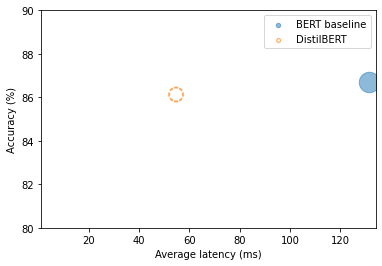

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
    
plot_metrics(perf_metrics, optim_type)

En el plot podemos ver que al usar un modelo mas pequenio hemos logrado reducir la latencia promedio significativamente. Todo esto nos costo un poco mas de 1% en reduccion de accuracy. Ahora vamos a intentar reducir ese gap incluyendo el distillation loss del teacher y encontrando buenos valores para $/alpha$ y $T$


## Encontrando buenos hiperparametros con Optuna

Para encontrar buenos valores para $\alpha$ y $T$, podriamos hacer un grid search sobre el espacio de parametros 2D. Pero una mucho mejor alternativa es usar Optuna[11], un framework de optimizacion diseniado para este tipo de tareas. Optuna formula el problema de busqueda en terminos de una funcion objetivo que se optimiza a traves de multiples _trials_. Por ejemplo, supongamos que queremos minimizar la ["banana function"] de Rosenbrock:

$f(x,y)=(1-x)^2 + 100(y-x^2)^2$

que es un test case famoso para frameworks de optimizacion. La funcion obtiene su nombre por los contornos curvos y tiene un minimo global en $(x,y) = (1,1)$. Encontrar el valle es un problema facil de optimizacion, pero converger en el minimo global no.

[11] T. Akiba et al., [“Optuna: A Next-Generation Hyperparameter Optimization Framework”](https://arxiv.org/abs/1907.10902), (2019).

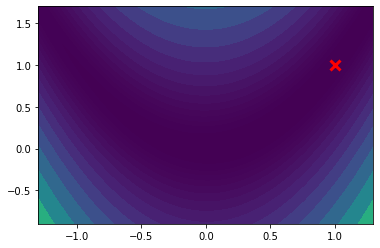

In [ ]:
def f(x, y):
    return (1-x)**2+100*(y-x**2)**2
    
X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

En Optuna, podemos encontrar el minimo de $f(x,y)$ definiendo una funcion `objective()` que retorna el valor de $f(x,y)$:

In [ ]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

El objeto `trial.suggest_float` especifica los rangos del parametro del que queremos muestrear uniformemente. Optuna recolecta multiples trials como un _study_, para crear uno solo pasamos la funcion `objective()` a `study.optimize()`:

In [ ]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2022-10-25 23:42:08,275] A new study created in memory with name: no-name-e182b6f7-7a2a-4702-bd49-9beb45bd38e7
[I 2022-10-25 23:42:08,284] Trial 0 finished with value: 1325.1802096813246 and parameters: {'x': 1.4170949862620748, 'y': -1.6319053178371363}. Best is trial 0 with value: 1325.1802096813246.
[I 2022-10-25 23:42:08,289] Trial 1 finished with value: 70.23223203480973 and parameters: {'x': -0.28336142149293986, 'y': 0.9084556086870896}. Best is trial 1 with value: 70.23223203480973.
[I 2022-10-25 23:42:08,294] Trial 2 finished with value: 58.884659011864834 and parameters: {'x': -0.6560461528480106, 'y': -0.3188842348341776}. Best is trial 2 with value: 58.884659011864834.
[I 2022-10-25 23:42:08,299] Trial 3 finished with value: 68.74345417893947 and parameters: {'x': -0.9876185855910125, 'y': 0.17045055646739105}. Best is trial 2 with value: 58.884659011864834.
[I 2022-10-25 23:42:08,308] Trial 4 finished with value: 103.64350332569806 and parameters: {'x': 1.58009110953689

Una vez termina el study, podemos encontrar los mejores parametros asi:

In [ ]:
study.best_params

{'x': 1.0353708517267453, 'y': 1.07255247628803}

Vemos que en mil trials, Optuna logro encontrar valores para $x$ y $y$ razonablemente cercanos al minimo global. Para usar Optuna en 🤗 Transformers, usamos una logica similar definiendo primero el espacio de hiperparametros que queremos optimizar. Adicionalmente a $\alpha$ y $T$, vamos a incluir el numero de epochs de entrenamiento:

In [ ]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

Correr la busqueda de hiperparametros con el Trainer es bastante simple; solo necesitamos especificar el numero de trials a correr y la direccion en la que queremos optimizar. Como queremos el mejor accuracy posible, especificamos `direction="maximize"` en el metodo `hyperparameter_search()` del trainer y pasamos el espacio de hiperparametros:

In [ ]:
# Best in local tests was with `n_trials=20`
# Colab ran out of memory
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=15, direction="maximize", hp_space=hp_space)

[I 2022-10-25 23:47:25,499] A new study created in memory with name: no-name-8dd888a3-bf30-4c3f-a4f4-298e57671ac8
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertF

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.238599,0.618387
2,0.373400,0.111944,0.836452
3,0.373400,0.071697,0.887097
4,0.128700,0.054473,0.905161
5,0.081000,0.045849,0.911935
6,0.081000,0.041714,0.914194
7,0.065600,0.040238,0.916452


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.197624,0.587742
2,0.311600,0.097173,0.826129
3,0.311600,0.065030,0.883871
4,0.111300,0.050499,0.900323
5,0.072300,0.042431,0.909032
6,0.072300,0.038007,0.914839
7,0.058200,0.035613,0.915806
8,0.052200,0.034790,0.917742


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.210661,0.578710
2,0.325500,0.109409,0.806452
3,0.325500,0.077900,0.868387
4,0.125100,0.065212,0.888065
5,0.089500,0.061292,0.894516


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.200169,0.573226
2,0.312300,0.101963,0.814194
3,0.312300,0.070795,0.875806
4,0.116500,0.057158,0.894839
5,0.079800,0.050487,0.903871
6,0.079800,0.048460,0.904839


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.197343,0.579355
2,0.309900,0.098690,0.820968
3,0.309900,0.067180,0.880968
4,0.112900,0.053041,0.897742
5,0.075000,0.045433,0.908065
6,0.075000,0.041710,0.911613
7,0.062100,0.040432,0.911935


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.203593,0.601613
2,0.322000,0.097935,0.831935
3,0.322000,0.064169,0.887419
4,0.112400,0.048928,0.902581
5,0.071200,0.040430,0.911290
6,0.071200,0.035673,0.918387
7,0.056100,0.032798,0.919032
8,0.049100,0.031151,0.921613
9,0.049100,0.030577,0.922581


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.196841,0.588387
2,0.310500,0.096908,0.825484
3,0.310500,0.064934,0.884839
4,0.111000,0.050463,0.900323
5,0.072200,0.042415,0.909677
6,0.072200,0.038003,0.914839
7,0.058100,0.035615,0.915484


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.201623,0.592258
2,0.317800,0.098507,0.829032
3,0.317800,0.065564,0.885484
4,0.112900,0.050696,0.901290
5,0.073000,0.042500,0.910323
6,0.073000,0.038018,0.915484
7,0.058600,0.035594,0.915484


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-7/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.200169,0.573226


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2022-10-26 00:47:53,083] Trial 8 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBer

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.195051,0.595161
2,0.309900,0.094145,0.833226
3,0.309900,0.061877,0.888387
4,0.108100,0.047237,0.901935
5,0.068400,0.038848,0.912258
6,0.068400,0.034088,0.919677
7,0.053500,0.031062,0.919677
8,0.046200,0.029158,0.924516
9,0.046200,0.028024,0.924516
10,0.042800,0.027671,0.923871


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-1000/py

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.407433,0.670000
2,0.639300,0.140583,0.851290
3,0.639300,0.071383,0.899677
4,0.161500,0.050562,0.916452
5,0.079900,0.041901,0.922903
6,0.079900,0.037147,0.928710
7,0.059900,0.034559,0.928065
8,0.051500,0.032823,0.929677
9,0.051500,0.031676,0.931290
10,0.047900,0.031425,0.930323


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-10/checkpoint

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.407433,0.670000
2,0.639300,0.140583,0.851290
3,0.639300,0.071383,0.899677
4,0.161500,0.050562,0.916452
5,0.079900,0.041901,0.922903
6,0.079900,0.037147,0.928710
7,0.059900,0.034559,0.928065
8,0.051500,0.032823,0.929677
9,0.051500,0.031676,0.931290
10,0.047900,0.031425,0.930323


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-11/checkpoint

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.407433,0.670000
2,0.639300,0.140583,0.851290
3,0.639300,0.071383,0.899677
4,0.161500,0.050562,0.916452
5,0.079900,0.041901,0.922903
6,0.079900,0.037147,0.928710
7,0.059900,0.034559,0.928065
8,0.051500,0.032823,0.929677
9,0.051500,0.031676,0.931290
10,0.047900,0.031425,0.930323


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-12/checkpoint

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.233719,0.627419
2,0.369800,0.105169,0.845806
3,0.369800,0.064967,0.893548
4,0.121600,0.047620,0.906774
5,0.072700,0.038614,0.918065
6,0.072700,0.033612,0.921935
7,0.055600,0.030540,0.922903
8,0.047700,0.028675,0.928710
9,0.047700,0.027560,0.927419


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-13/checkpoint

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.410003,0.667419
2,0.641300,0.144047,0.847419
3,0.641300,0.073573,0.898065
4,0.165000,0.052177,0.915806
5,0.082300,0.043380,0.920968
6,0.082300,0.038638,0.927097


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.410003,0.667419
2,0.641300,0.144047,0.847419
3,0.641300,0.073573,0.898065
4,0.165000,0.052177,0.915806
5,0.082300,0.043380,0.920968
6,0.082300,0.038638,0.927097
7,0.062200,0.036070,0.927097
8,0.054100,0.034549,0.928387


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-2500
Configuration saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-2500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-2500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-2500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-2500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48


El metodo `hyperparameter_search()` regresa un objeto `BestRun`, que contiene el valor del objetivo que fue maximizado (por default, la suma de todas las metricas) y los hiperparametros que uso para esa corrida:

In [ ]:
print(best_run)

El valor de $\alpha$ nos dice que la mayoria de la senial de entrenamiento viene del termino de knowledge distillation. Actualicemos nuestros argumentos de entrenamiento con estos valores y corramos el entrenamiento final:

In [ ]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)
    
# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

Logramos entrenar el student para igualar al teacher en accuracy, a pesar de que tiene mitad de los parametros. Carguemos el modelo al hub para uso futuro:

In [ ]:
distil_trainer.push_to_hub("training complete")

## Benchmarks de nuestro modelo distilled

Ahora que tenemos un mejor student, creemos un pipeline y rehagamos nuestros benchmarks para ver como desempenio en el test set:

In [ ]:
distilled_ckpt = f"{user}/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Para poner estos resultados en contexto los podemos visualizar con nuestra funcion `plot_metrics()`:

In [ ]:
plot_metrics(perf_metrics, optim_type)

Como esperabamos, el tamanio del modelo y la latencia basicamente se mantuvieron iguales, pero el accuracy ha mejorado e incluso sobrepasa el performance del teacher. Una forma de interpretar estos resultados es que el teacher probablemente no ha sido fine-tuned sistematicamente como el student. Todavia podemos comprimir nuestro modelo con la tecnica de quantization.

## Haciendo modelos mas rapidos con Quantization

Ya hemos visto que KD puede reducir el costo computacional y de memoria de correr inferencia al transferir informacion del teacher a un student mas pequenio. Quantization toma un nefoque diferente; en vez de reducir el numero de computaciones, las hace mas eficientes al representar pesos y activaciones con tipos de datos de baja precision como enteros de 8-bits (INT8) en vez de los usuales floating points de 32-bits (FP32). Reducir el numero de bits quiere decir que el modelo resutlante requiere mucho menos memoria y operaciones como multiplicacion de matrices pueden ser realizadas mas rapido con aritmetica de enteros. Lo impresionante es que estos logros no afectan casi nada el accuracy del modelo.

La idea fundamental detras de quantization es que podemos "discretizar" los floating point values $f$ en cada tensor mapeando su rango $[f_{max}, f_{min}]$ a un rango mas pequenio $[q_{max}, q_{min}]$ de fixed-point values $q$, y distribuir linealmente todos los valores de por medio. Matematicamente, este mapeo se describe con la siguiente ecuacion:

$f = \frac{f_{max} - f_{min}}{q_{max} - q_{min}}(q-Z) = S(q-Z)$

donde el factor de scale $S$ es un numero floating-point positivo y la constante $Z$ tiene el mismo tipo que $q$ y se conoce como el _zero point_ porque corresponde al quantized value del floating-point value $f = 0$. Noten que el mapa tiene que ser afin[12] para que podamos obtener los numeros floating-point de regreso cuando reversesmos el proceso. 

Una de las principales razones por las cuales los transformers (y DNN en general) son buenos candidatos para quantization es que los pesos y activaciones tienden a tomar valores en rangos relativamente pequenios. Esto significa que no tenemos que apretar todo el rango de posibles numeros FP32 al rango de numeros representados por INT8 ($2^8 = 256$). Para ver esto, agarremos una de las matrices de pesos de attention de nuestro modelo distilado y grafiquemos la distribucion de frecuencia de los valores:

[12] Un mapa afin (affine en ingles) es una nombre chilero para el mapa $y = Ax + b$ con el que ya estan familiarizados por las capas lineares de una NN. Basicamente una transformacion lineal.

In [ ]:
import matplotlib.pyplot as plt
state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

Como podemos ver, los valores de los pesos estan distribuidos en el pequenio rango $[-0.1, 0.1]$ alrededor de cero. Ahora, supongamos que queremos quantize este tensor como un signed 8-bit integer. En este caso, el rango de posibles valores para nuestros enteros es $[q_{max}, q_{min}] = [-128, 127]$. El zero point coincide con el cero de FP32 y el factor de escala se calcula con la ecuacion anterior:

In [ ]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

Para obtener el tensor quantized, solo tenemos que invertir el mapeo $q = f/S+Z$, restringier los valores usando el metodo `clamp()` de PyTorch, redondearlos al entero mas cercano, y representar el resultado como un tipo de dato `torch.int8` usando el metodo `Tensor.char()`:

In [ ]:
(weights / scale + zero_point).clamp(-128, 127).roun().char()

En PyTorch podemos simplificar la conversion con la funcion `quantize_per_tensor()` junto con un tipo de dato quantized, `torch.qint`, que esta optimizado para operaciones aritmeticas sobre enteros:

In [ ]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

Para terminar nuestro pequenio analisis, comparemos cuanto tiempo toma calcular la multiplicacion de dos tensores de pesos con valores FP32 y INT8. Podemos multiplicar los tensores FP32 con el operador `@` de PyTorch:

In [ ]:
%%timeit
weights @ weights

Para los tensores quantized necesitamos la clase wrapper `QFunctional` para poder realizar operaciones con el tipo de dato `torch.qint8`:

In [ ]:
from torch.nn.quantized import QFunctional
q_fn = QFunctional()

Esta clase soporta varias operaciones fundamentales como suma y en nuestro caso multiplicacion:

In [ ]:
%%timeit
q_fn.mul(quantized_weights, quantizied_weights)

Comparado a nuestra computacion con FP32, usando tensores con INT8 es casi 100x mas rapido. 

Como los numeros INT8 tienen 4x menos bits que los numeros FP32, quantization tambien reduce la memoria requerida por un factor de 4. En nuestro ejemplo simple podemos verificar esto comparando el tamanio de almacenamiento de nuestro tensor de pesos y su equivalente quantized usando la funcion `Tensor.storage()` y la funcion `getsizeof()` del modulo `sys` de Python:

In [ ]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

Para transformers completos, la tasa de compresion depende de las capas que son quantized (tipicamente solo las capas lineales).

Cual es el trade-off con quantization? Cambiar la precision de todas las computaciones en nuestro modelo introduce pequenias perturbaciones en cada punto del grafo computacional del modelo, lo cual puede componerse (compound) y afectar el desempenio del modelo. Para DNNs, hay tres enfoques principales para quantization:

_Dynamic quantization_

_Static quantization_

_Quantization-aware training_

El cuello de botella principal para correr inferencia con transformers es la computacion y memoria asociados con el numero de pesos en estos modelos. Por esta razon, _dynamic quantization_ es el mejor enfoque actual para modelos transformers en NLP. En modelos de computer vision mas pequenios el factor limitante es la memoria de las activaciones, por lo que _static quantization_ es usado. 

Implementar _dynamic quantization_ en Pytorch es bastante simple y se puede hacer en una sola linea:

In [ ]:
from torch.quantization import quantize_dynamic

model_ckpt = f"{user}/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
            .from_pretrained(model_ckpt).to("cpu"))
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)


Aqui pasamos el modelo de precision completa a `quantize_dynamic()` y especificamos el conjunto de clases de capas de PyTorch que queremos quantize. El argumento `dtype` especifica la precision que queremos y puede ser `fp16` o `qint8`. Una buena practica es escoger la precision mas baja que podamos tolerar con respecto a nuestras metricas de evaluacion. En este notebook vamos a usar INT8.

## Benchmark del modelo quantized

Con nuestro modelo ya quantized, pasemoslo a traves de nuestro benchmark y visualicemos los resultados:

In [ ]:
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

El modelo quantized es casi la mitad del tamanio del distilled e incluso tiene un pequenio boost en accuracy.

## Optimizando inferencia con ONNX y el ONNX Runtime

TBC